In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn_extra.cluster import KMedoids
import os, pickle

In [179]:
### open the data, combine energy with the coords. 
def get_data(path, skip_row, remove=0, explicit=False):
    csv_files = os.listdir(path)
    csv_files = [f for f in csv_files if 'csv' in f]
    csv_energy = sorted([f for f in csv_files if 'energy' in f])
    csv_coords = sorted([f for f in csv_files if 'coords' in f])
    replica_e_data = {}
    replica_c_data = {}
    skip = []
    if len(csv_energy) == 0:
        replica_c_data[0] = pd.read_csv(os.path.join(path,csv_coords[0]), skiprows = skip).iloc[remove:,:]
        return replica_c_data
    if explicit:
        reps = [0]
    else:
        reps = [0,1,2,3,4,5,6,7,8,9]
    for c,e,rep in zip(csv_coords, csv_energy, reps):
        if skip_row:
            skip = lambda x:(x)%10 != 0
        replica_c_data[rep] = pd.read_csv(os.path.join(path,c), skiprows = skip).iloc[remove:,:]
        replica_e_data[rep] = pd.read_csv(os.path.join(path,e), skiprows = skip).iloc[remove:,:]
    return replica_c_data, replica_e_data

def combine_dicts(d1,d2):
    new_dict = {}
    for kv1,kv2 in zip(d1.items(),d2.items()):
        new_dict[kv1[0]] = pd.concat([kv1[1],kv2[1]], axis=0).reset_index().drop(columns='index')
    return new_dict

##### WHAT PART OF THE PEPTIDE TO ANALYZE, paper uses [2,28)
start = 2
stop = 28 

## important parameter:
explicit = False

remove = 1000 # 1000 for the REMD, 100 for tossing the 1st 40ns of the explicit solvent sims
combine_8_1s= False
if combine_8_1s:
    # this keeps the frame correct for both of the data sets, but index is over both
    path = './REMD_extracted_data/8_1_test32_REMD_1/'
    replica_c_data_32, replica_e_data_32 = get_data(path, skip_row=False, remove=remove)
    path = './REMD_extracted_data/8_1_test37_REMD_2/'
    replica_c_data_37, replica_e_data_37 = get_data(path, skip_row=False, remove=remove)
    replica_c_data = combine_dicts(replica_c_data_32, replica_c_data_37)
    replica_e_data = combine_dicts(replica_e_data_32, replica_e_data_37)
    size_32 = replica_c_data_32[0].shape[0]
    size_37 = replica_c_data_37[0].shape[0]
    
## pick which you want to run: 
# path = './REMD_extracted_data/8_1_test32_REMD_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

# path = './REMD_extracted_data/8_1_test37_REMD_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

# path = './REMD_extracted_data/struct81_cov_REMD/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

#### note this first two data has incorrect distances for 3/4 for the time series due to the vmd processing
path = './REMD_extracted_data/8_1_CA_noncov_REMD/'
replica_c_data, replica_e_data = get_data(path, skip_row=True, remove=remove)
### corrected the distances here...only use these for distance analysis though!
# path = './REMD_extracted_data/8_1_CA_noncov_REMD/new/'
# replica_c_data = get_data(path, skip_row=False, remove=remove)
# replica_c_data[0] = replica_c_data[0].rename(columns={'frame':'step', 'rgyr':'Rgyr'})

## if explicit == True use the following:
# path = './Explicit_solv_extracted_data/8_1_test36_EXPLICIT_SOLV_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/8_1_test38_EXPLICIT_SOLV_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/struct81_noncov_EXPLICIT_SOLV/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)
 
# path = './Explicit_solv_extracted_data/struct81_noncov_EXPLICIT_SOLV/centered/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)
# replica_c_data[0] = replica_c_data[0].rename(columns={'frame':'step', 'rgyr':'Rgyr'})

# path = './Explicit_solv_extracted_data/struct81_cov_EXPLICIT_SOLV_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/8_1-CA_best_conf_new_EXPLICIT_SOLV_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

possible_files = {'test32':'Gen4_t32', 'test37':'Gen4_t37','_noncov_REMD':'Gen4+CA_REMD',
                  'struct81_cov':'Gen4-CA_explicit_1','best_conf':'Gen4-CA_explicit_2','noncov_EXPLICIT':'Gen4+CA_explicit',
                  'test36':'Gen4_explicit_t36', 'test38':'Gen4_explicit_t38', '_cov_REMD':'Gen4-CA_REMD'}
for ele in possible_files:
    if ele in path:
        save_name = possible_files[ele]
    if combine_8_1s:
        save_name = 'Gen4_combined'
print(save_name)

Gen4+CA_REMD


In [70]:
# 2 fs per step
# 1000 steps per run
# 10 runs per frame

In [180]:
def int_to_cart(df):
    internal_coord_names = [n for n in list(df) if 'phi' in n or 'psi' in n]
    sin_data = np.sin(df[internal_coord_names]*np.pi/180.0)
    sin_data.columns = [ele+'_y' for ele in internal_coord_names]
    cos_data = np.cos(df[internal_coord_names]*np.pi/180.0)
    cos_data.columns = [ele+'_x' for ele in internal_coord_names]
    df = pd.concat([df, cos_data,sin_data], axis=1).drop(columns=internal_coord_names)
    name_order = ('phi_x', 'phi_y', 'psi_x','psi_y')
    names_not_phipsi = [ele for ele in list(df) if 'phi' not in ele and 'psi' not in ele]
    names = [pp[:-5] for pp in list(df) if 'phi' in pp or 'psi' in pp]
    names = names[:int(len(names)/2):2]
    names_new = []
    for name in names:
        for ele in name_order:
            names_new.append(str(name)+str(ele))
    df = df[names_new+names_not_phipsi]
    return df

steps = {}
SS = {}
## deal with cases where 'step' or 'Frame' is in df or the other 
for rep in replica_c_data:
    replica_c_data[rep] = int_to_cart(replica_c_data[rep])
    SS[rep] = replica_c_data[rep]['SS']
    if 'step' in replica_c_data[rep]:
        steps[rep] = replica_c_data[rep]['step']
        inds = list(steps[rep].index)
        inds = [ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['step', 'SS'])
        replica_c_data[rep].index=inds
    else:
        steps[rep] = replica_c_data[rep]['Frame']
        inds = list(steps[rep].index)
        inds = [ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['Frame','SS'])
        replica_c_data[rep].index=inds
        

In [181]:
keep_phipsi = True
subset_phipsi = True ## use all residue or a smaller window, if using phi/psi make this true
keep_dist = False
keep_sasa_rgyr = False
if subset_phipsi:
    resid_subset = [str(i) for i in range(start,stop)]

to_drop = []
sasa_rgyr_names = [n for n in list(replica_c_data[0]) if 'SASA' in n or 'gyr' in n]
phi_psi_names = [n for n in list(replica_c_data[0]) if 'phi' in n or 'psi' in n]
distance_names = [n for n in list(replica_c_data[0]) if n not in phi_psi_names+sasa_rgyr_names]
if not keep_sasa_rgyr:
    to_drop += sasa_rgyr_names
if not keep_phipsi:
    to_drop += phi_psi_names
if not keep_dist:
    to_drop += distance_names
if subset_phipsi:
    to_drop += [ele for ele in phi_psi_names if ele.split('_')[1] not in resid_subset]
    
if explicit:
    replica_c_data[0] = replica_c_data[0].drop(columns=to_drop)  
else:
    rep_c_data_rgyr_sasa = {ele:None for ele in replica_c_data}
    rep_c_data_distances = {ele:None for ele in replica_c_data}
    for rep in range(10):
        try:
            rep_c_data_distances[rep] = replica_c_data[rep][to_drop]
            rep_c_data_rgyr_sasa[rep] = replica_c_data[rep][sasa_rgyr_names]
            replica_c_data[rep] = replica_c_data[rep].drop(columns=to_drop)
        except:
            pass

In [182]:
non_dist_names_ = list(rep_c_data_distances[0])
key_phrases = ['rgyr', 'SASA', 'SS', 'Frame', 'phi', 'psi', 'frame', 'step', 'Rgyr']
non_dist_names = []
for name in non_dist_names_:
    incorrect = 0
    for key in key_phrases:
        if key in name:
            incorrect += 1
    if incorrect == 0:
        non_dist_names.append(name)
for rep in range(10):
    try:
        rep_c_data_distances[rep] = rep_c_data_distances[rep][non_dist_names]
    except:
        pass

In [27]:
## cluster the data with agglomerative clustering
## use the lowest temp data for the clustering
save = False
recluster = False
X = replica_c_data[0]

if recluster:
    dist_thresh = 50
    agg_clust = AgglomerativeClustering(distance_threshold=dist_thresh, n_clusters=None, linkage='ward').fit(X)
else:
    agg_clust = pickle.load(open('./{}_agg_clusters_explict_solv_{}.pkl'.format(save_name, explicit),'rb'))
if save:
    pickle.dump(agg_clust, open('./{}_agg_clusters_explict_solv_{}.pkl'.format(save_name, explicit), 'wb'))

In [28]:
print(agg_clust.n_clusters_)

96


In [144]:
# pickle.dump(agg_clust, open('./full_new_{}_agg_clusters_explict_solv_{}.pkl'.format(save_name, explicit), 'wb'))

In [29]:
def get_cluster_rep(data):
    kmedoids = KMedoids(n_clusters=1).fit(data)
    center_ind = data.iloc[int(kmedoids.medoid_indices_[0]),:].name
    return kmedoids.cluster_centers_, center_ind

def find_all_clust_reps(data, cluster_obj, random_cluster_eles=50):
    labels = cluster_obj.labels_
    sorted_total_clusters = sorted(list(set(labels)))
    print(sorted_total_clusters)
    centers = []
    center_inds = []
    cluster_size_fract = []
    total_size = cluster_obj.labels_.shape[0]
    cluster_examples = []
    clusters_for_network = {}
    for i in sorted_total_clusters:
        cluster = data[labels == i]
        cluster_size = cluster.shape[0]
        cluster_size_fract.append(cluster_size/total_size)
        center, cent_ind = get_cluster_rep(cluster)
        elements = [ele for ele in list(cluster.index) if ele != cent_ind]
        if cluster_size < random_cluster_eles:
            cluster_examples.append(elements)
        else:
            elements = list(np.random.choice(elements, random_cluster_eles))
            cluster_examples.append(elements) 
#         clusters_for_network[i] = data.loc[elements]
        clusters_for_network[i] = list(cluster.index)
        centers.append(center)
        center_inds.append(cent_ind)
    return centers, cluster_size_fract, center_inds, cluster_examples, clusters_for_network

def example_to_example_frame(step_df, cluster_examples):
    cluster_frames = []
    frames = [list(step_df[ele].values) for ele in cluster_examples]
    return frames  

def make_cluster_df(clust_obj, data, step_df):
    assert data.shape[0] == step_df.shape[0]
    X_centers, cluster_size_fract, center_inds, cluster_examples, clusters_for_network = find_all_clust_reps(data, clust_obj)
    frames = list(step_df.loc[center_inds].values)
    example_frames = example_to_example_frame(step_df, cluster_examples)
    center_size_df = pd.DataFrame({'frame':frames, 'center_index':center_inds, 
                                   'cluster_size':cluster_size_fract, 'example_frames':example_frames})
    return X_centers, center_size_df, clusters_for_network

X_centers, center_size_df, clusters_for_network = make_cluster_df(agg_clust, X, steps[0])

## X_centers: the vector for the cluster center from the medoid clustering
## center_size_df: the df linking the center index in the data to the actual frame and the cluster size

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


In [216]:
#### GENERALLY YOU WILL SKIP THIS CELL, only for MP to CA interactions

## to get data for the MP to CA interaction analysis run the following:
MP_noncov_CA_REMD = False
if MP_noncov_CA_REMD:
    clustered_frames = {}
    ordered_clusters = sorted([(k,len(v)) for k,v in clusters_for_network.items()], key=lambda X:X[1], reverse=True)
    for i,c_num in enumerate(ordered_clusters):
        clustered_frames[i+1] = steps[0].loc[clusters_for_network[c_num[0]]].values

    for c in clustered_frames:
        clustered_frames[c] = ['Frame_'+str(ele)+'.pdb' for ele in clustered_frames[c]]
    pickle.dump(clustered_frames, open('{}_clustered_frames.pkl'.format(save_name), 'wb'))

#############
# RUN THE REST OF THIS ANALYSIS ON LOCAL COMP...
# 1) download the pkl
# 2) inside lig_MP_interactions.py alter path to pdbs, path to the pickle and what clusters to analyze
# 3) run the python script

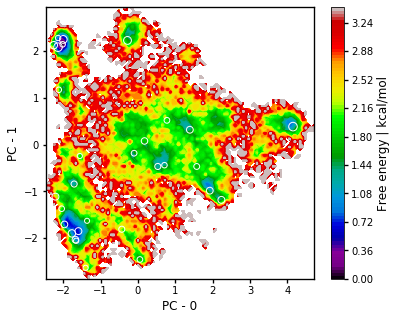

In [30]:
### do PCA on coords / subsets of them
pca_fitting = True
scale_data = False
savef = True

data = replica_c_data[0]

if scale_data:
    ss = StandardScaler()
    data = ss.fit_transform(data)

if pca_fitting:
    pca = PCA(n_components=10)
    if scale_data:
        data = ss.transform(data)
    data_pca = pca.fit_transform(data)
else:
    data_pca = pca.transform(data)

cluster_size_fract = list(center_size_df['cluster_size'])
c = agg_clust.labels_
X_centers = np.vstack(X_centers)
pca_x_center = pca.transform(X_centers)

largest_fract = max(cluster_size_fract)
norm = cm.colors.Normalize(vmax=largest_fract+0.03, vmin=0)

p_dim_1 = 0
p_dim_2 = 1

## free energy:
fig, ax = plt.subplots(1,1,figsize=(6,5))
fig, ax, misc = pyemma.plots.plot_free_energy(data_pca[:,p_dim_1],data_pca[:,p_dim_2],ax=ax, legacy=False,
                                              kT=0.59249587,cbar_label='Free energy | kcal/mol',
                                              ncontours=100,nbins=100)
top_x = True
x_value = -30 # get the top 30 clusters 
if top_x:
    lg_clusters = center_size_df['cluster_size'].sort_values()[x_value:]
    lg_clusters_ind = list(lg_clusters.index)
    pca_x_center_ = pca_x_center[lg_clusters_ind,:]
    cluster_size_fract = list(lg_clusters.values)
    
im = ax.scatter(pca_x_center_[:,p_dim_1],pca_x_center_[:,p_dim_2], s=np.asarray(cluster_size_fract)*2000, alpha=1, facecolors='none',edgecolor='w', linewidth=1, norm=norm) # c=cluster_size_fract, cmap=c_map, edgecolor='k', norm=norm)
ax.set_xlabel('PC - {}'.format(p_dim_1), fontname='Dejavu Sans', fontsize=12)
ax.set_ylabel('PC - {}'.format(p_dim_2), fontname='Dejavu Sans', fontsize=12)
ax.set_aspect('auto')
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
conts = misc['mappable']
for c in conts.collections:
    c.set_edgecolor("face")
cbar = misc['cbar']
cbar.ax.tick_params(width=width)
text = cbar.ax.yaxis.label
from matplotlib.font_manager import FontProperties
font = FontProperties(family='Dejavu Sans', size=12)
text.set_font_properties(font)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontname='Dejavu Sans', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(6,5)
if savef:
    plt.savefig('{}_PCA_{}-to-{}.svg'.format(save_name,start,stop), format='svg', dpi=1000, bbox_inches='tight')

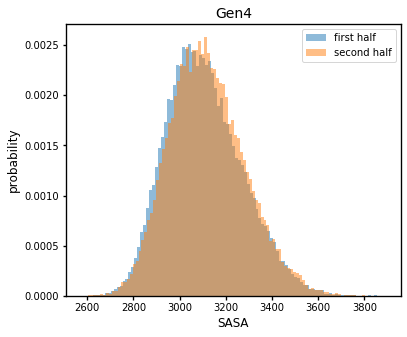

In [107]:
### looking at the 1st and 2nd half of the REMD simulation for a ROUGH idea of convergence

key_word = 'SASA'
if 'CA' in save_name:
    rep_c_data_rgyr_sasa_1 = rep_c_data_rgyr_sasa[0].iloc[:int(rep_c_data_rgyr_sasa[0].shape[0]/2),:]
    rep_c_data_rgyr_sasa_2 = rep_c_data_rgyr_sasa[0].iloc[int(rep_c_data_rgyr_sasa[0].shape[0]/2):,:]
else:
    rep_c_data_rgyr_sasa_1 = pd.concat((rep_c_data_rgyr_sasa[0].iloc[0:int(size_32/2),:], rep_c_data_rgyr_sasa[0].iloc[size_32:int(size_32+int(size_37/2))]))
    rep_c_data_rgyr_sasa_2 = pd.concat((rep_c_data_rgyr_sasa[0].iloc[int(size_32/2):size_32] , rep_c_data_rgyr_sasa[0].iloc[int(size_32+int(size_37/2)):]))
if save_name == 'Gen4_combined':
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.hist(rep_c_data_rgyr_sasa_1['{}_protein'.format(key_word)], 100, alpha=0.5, density=True, label='first half')
    ax.hist(rep_c_data_rgyr_sasa_2['{}_protein'.format(key_word)], 100, alpha=0.5, density=True, label='second half')
    plt.title('Gen4', fontsize=14, fontname='Dejavu Sans')
    save_n_hist = '{}_{}_first-half_v_sec-half_Gen4.svg'.format(save_name,key_word)
    
if save_name == 'Gen4+CA_REMD':
    ax.hist(rep_c_data_rgyr_sasa_1['{}'.format(key_word)], 100, alpha=0.5, density=True, label='first half')
    ax.hist(rep_c_data_rgyr_sasa_2['{}'.format(key_word)], 100, alpha=0.5, density=True, label='second half')
    plt.title('Gen4+CA', fontsize=14, fontname='Dejavu Sans')
    save_n_hist = '{}_{}_first-half_v_sec-half_Gen4+CA.svg'.format(save_name,key_word)
    
if save_name == 'Gen4-CA_REMD':
    ax.hist(rep_c_data_rgyr_sasa_1['{}_protein_and_ca'.format(key_word)], 100, alpha=0.5, density=True, label='first half')
    ax.hist(rep_c_data_rgyr_sasa_2['{}_protein_and_ca'.format(key_word)], 100, alpha=0.5, density=True, label='second half')
    plt.title('Gen4-CA', fontsize=14, fontname='Dejavu Sans')
    save_n_hist = '{}_{}_first-half_v_sec-half_Gen4-CA.svg'.format(save_name,key_word)


plt.legend()
ax.set_xlabel('{}'.format(key_word), fontname='Dejavu Sans', fontsize=12)
ax.set_ylabel('probability', fontname='Dejavu Sans', fontsize=12)
ax.set_aspect('auto')
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
plt.savefig(save_n_hist, format='svg', dpi=1000, bbox_inches='tight')
plt.show()

For prepping for the angle difference analysis

In [129]:
## reload the data (note this should not be used in combo with below analysis) for phi/psi analysis
## better this than back calculating the angles since it just adds error due to rounding
#### IMPORTANT: get just the phi/psi (not transformed to X/Y) of interest and load the clustered data ####

from scipy.stats import circstd
agg_clust_size = get_cluster_size(agg_clust)
agg_clust_size_sorted = sorted([(k,v) for k,v in agg_clust_size.items()],reverse=True, key=lambda x:x[1])
def get_clust_mask(c_order, c_to_size_list, k=0):
    c_name = c_to_size_list[k][0]
    return c_order==c_name

mean_angles_all_clust = []
std_angles_all_clust = []
for i in range(len(agg_clust_size_sorted)):
    k_val = i
    c_inds = get_clust_mask(agg_clust.labels_, agg_clust_size_sorted, k=k_val)
    clust_data = replica_c_data[0].iloc[c_inds, :]
    resi_names = list(clust_data)
    stds = []
    means = []
    for i in range(start,stop):
        resi = [res for res in resi_names if '_'+str(i)+'_' in res]
        resi_data = clust_data[resi]
        resi_cos = np.cos(resi_data*np.pi/180.0).sum(axis=0)/resi_data.shape[0]
        quad_correct = np.zeros(resi_cos.shape)
        quad_correct[resi_cos.values<0] = 180.0
        resi_sin = np.sin(resi_data*np.pi/180.0).sum(axis=0)/resi_data.shape[0]
        avg_data = np.arctan(resi_sin/resi_cos)*180.0/np.pi
        avg_data = avg_data + quad_correct
        avg_data[avg_data>180] = avg_data[avg_data>180]-360
        std_data =[circstd(resi_data.iloc[:,0]*np.pi/180)*180/np.pi, circstd(resi_data.iloc[:,1]*np.pi/180)*180/np.pi]
        stds += std_data
        means.append(avg_data)

    #     plt.scatter(resi_data.iloc[:,0], resi_data.iloc[:,1], c='c', edgecolor='k', linewidth=0.5, s=10)
    #     plt.show()
    mean_angles = pd.concat(means)
    stds = np.asarray(stds)
    mean_angles_all_clust.append(mean_angles.values)
    std_angles_all_clust.append(stds)


In [130]:
save_cell = False
print(save_name)
if save_name == 'Gen4-CA_explicit_1':
    save_name = 'Gen4-CA'
if save_cell:
    pickle.dump([mean_angles_all_clust,std_angles_all_clust], open('./{}_cluster_means_stds.pkl'.format(save_name), 'wb'))

Gen4+CA_REMD


In [31]:
save_cell = True
lg_clusters = lg_clusters.to_frame()
lg_clusters['PC1'] = pca_x_center_[:,p_dim_1]
lg_clusters['PC2'] = pca_x_center_[:,p_dim_2]
if save_cell:
    lg_clusters.to_csv('./new_cluster_size_pca_1_2_{}_range_{}-{}.csv'.format(save_name,start,stop))

k4_n_pfp_s K4 sidechain N - pfps bridging S


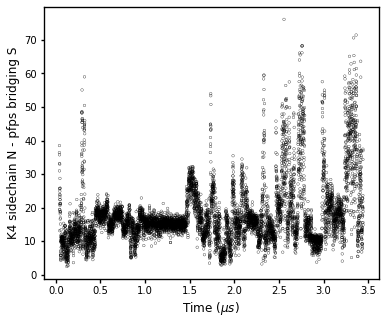

k6_n_pfp_s K6 sidechain N - pfps bridging S


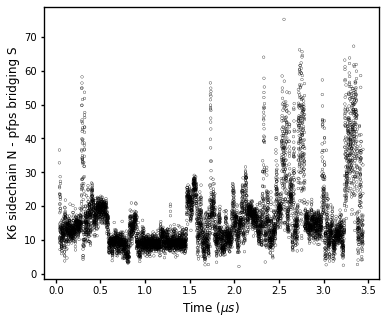

k9_n_pfp_s K9 sidechain N - pfps bridging S


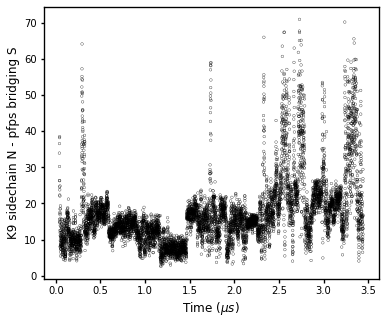

m1_cb_pfp_s M1 Cb - pfps bridging S


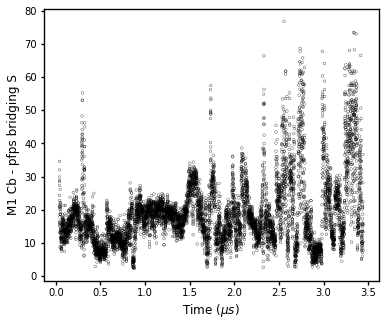

y5_cb_pfp_s Y5 Cb - pfps bridging S


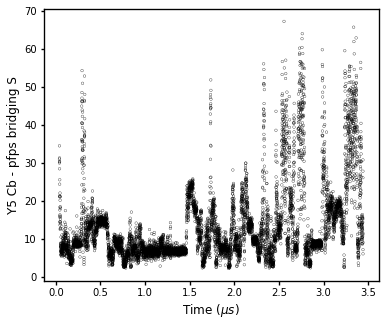

f12_cb_pfp_s F12 Cb - pfps bridging S


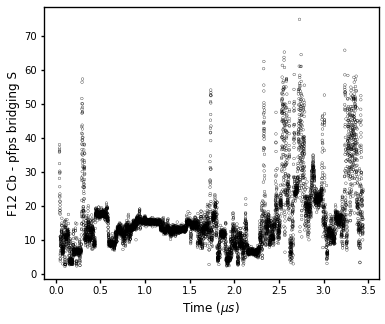

f13_cb_pfp_s MF13 Cb - pfps bridging S


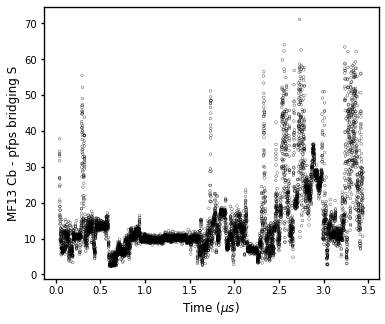

f15_cb_pfp_s F15 Cb - pfps bridging S


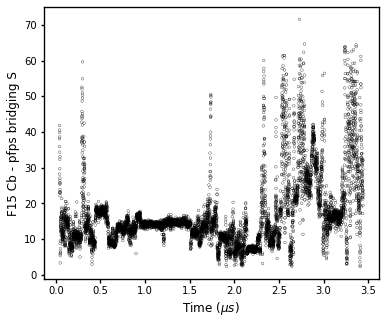

l16_cb_pfp_s L16 Cb - pfps bridging S


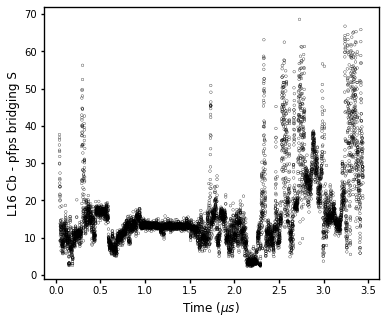

l19_cb_pfp_s L19 Cb - pfps bridging S


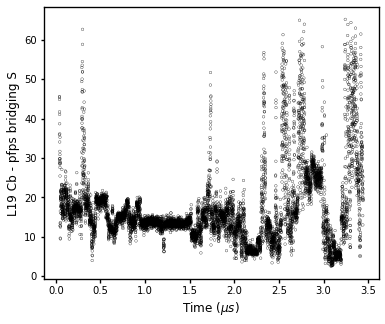

y25_cb_pfp_s Y25 Cb - pfps bridging S


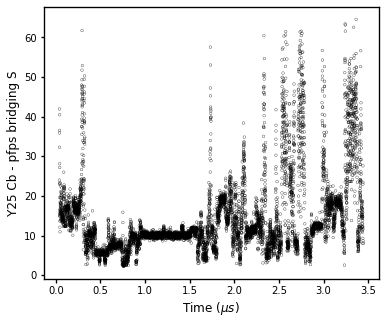

c11_s_pfp_s C11 S - pfps bridging S


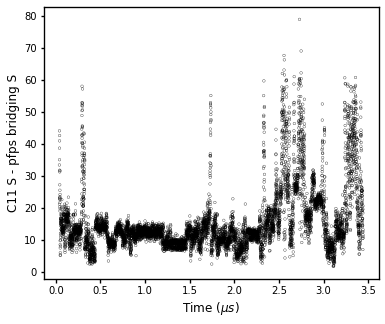

In [11]:
#### ONLY FOR EXPLICIT SOLV GEN4 + noncov CA
save_cell = False
distances = ['k4_n_pfp_s','k6_n_pfp_s','k9_n_pfp_s','m1_cb_pfp_s','y5_cb_pfp_s','f12_cb_pfp_s','f13_cb_pfp_s','f15_cb_pfp_s','l16_cb_pfp_s','l19_cb_pfp_s','y25_cb_pfp_s','c11_s_pfp_s']
names = ['K4 sidechain N - pfps bridging S','K6 sidechain N - pfps bridging S','K9 sidechain N - pfps bridging S',
        'M1 Cb - pfps bridging S','Y5 Cb - pfps bridging S','F12 Cb - pfps bridging S','MF13 Cb - pfps bridging S',
        'F15 Cb - pfps bridging S','L16 Cb - pfps bridging S','L19 Cb - pfps bridging S', 'Y25 Cb - pfps bridging S',
        'C11 S - pfps bridging S']
for dist,name in zip(distances,names):
    print(dist, name)
    replica_c_data[0]['time'] = 0.000400*replica_c_data[0]['step']
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.set_xlabel('Time ($\mu s$)', fontname='Dejavu Sans', fontsize=12)
    ax.set_ylabel(name, fontname='Dejavu Sans', fontsize=12)
    width=1.35
    ax.spines['left'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    ax.spines['top'].set_linewidth(width)
    ax.tick_params(width=width)
    ax.scatter(replica_c_data[0]['time'], replica_c_data[0][dist], c='', edgecolor='k', s=7, linewidth=0.3)
    if save_cell:
        plt.savefig('MP_dist_to_pfp_noncov_explicit_{}.svg'.format(dist), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()
    

<Figure size 432x288 with 0 Axes>

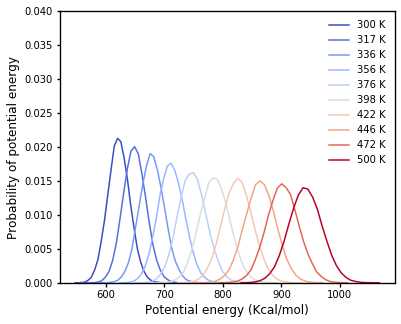

In [65]:
## PE overlaps from REMD
if save_name == 'Gen4-CA_explicit_1': # there was a saving naming error, this corrected it.
    save_name = 'Gen4-CA_REMD'
save_cell = True
PEs = []
temps = [300,317,336,356,376,398,422,446,472,500]
colors = [(ele-300)/(200) for ele in temps]
cmap = 'coolwarm'
c_mapper = cm.get_cmap(cmap)
colors = [c_mapper(ele) for ele in colors]
for rep in replica_e_data:
#     PEs.append(replica_e_data[rep]['Nonbond'])
    PEs.append(replica_e_data[rep]['Total'])

to_plot = []
for PE, temp in zip(PEs,temps):
    data, bins, patches = plt.hist(PE,bins=30,density=True, label=temp)
    xs = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    to_plot.append([data,xs])
    plt.clf()

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_xlabel('Potential energy (Kcal/mol)', fontname='Dejavu Sans', fontsize=12)
ax.set_ylabel('Probability of potential energy', fontname='Dejavu Sans', fontsize=12)
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
ax.set_ylim(bottom=0.0, top=0.04)
for data_xs, c, t in zip(to_plot, colors, temps):
    ax.plot(data_xs[1],data_xs[0],c=c, label=str(t)+' K')
plt.legend(frameon=False)
if save_cell:
    plt.savefig('replica_PE_{}.svg'.format(save_name), format='svg', dpi=1000, bbox_inches='tight')
plt.show()

['step', 'Rgyr', 'SASA', 'SS', 'c_m1', 'c_k4', 'c_k6', 'c_k9', 'c_f15', 'c_h18', 'c_l24', 'c_y25', 'm1a_g29a', 'm1_l19', 'm1_l24', 'y5_f15', 'y5_l19', 'm7_m27', 'f12_m27', 'f13_l16', 'f15_l19', 'f15_l24', 'l16_y25', 'l19_m27', 'k4_n_pfp_s', 'k6_n_pfp_s', 'k9_n_pfp_s', 'm1_cb_pfp_s', 'y5_cb_pfp_s', 'f12_cb_pfp_s', 'f13_cb_pfp_s', 'f15_cb_pfp_s', 'l16_cb_pfp_s', 'y25_cb_pfp_s', 'MET_1_phi', 'MET_1_psi', 'ASN_2_phi', 'ASN_2_psi', 'GLN_3_phi', 'GLN_3_psi', 'LYS_4_phi', 'LYS_4_psi', 'TYR_5_phi', 'TYR_5_psi', 'LYS_6_phi', 'LYS_6_psi', 'MET_7_phi', 'MET_7_psi', 'ALA_8_phi', 'ALA_8_psi', 'LYS_9_phi', 'LYS_9_psi', 'ALA_10_phi', 'ALA_10_psi', 'CYS_11_phi', 'CYS_11_psi', 'PHE_12_phi', 'PHE_12_psi', 'PHE_13_phi', 'PHE_13_psi', 'ALA_14_phi', 'ALA_14_psi', 'PHE_15_phi', 'PHE_15_psi', 'LEU_16_phi', 'LEU_16_psi', 'GLU_17_phi', 'GLU_17_psi', 'HSD_18_phi', 'HSD_18_psi', 'LEU_19_phi', 'LEU_19_psi', 'LYS_20_phi', 'LYS_20_psi', 'LYS_21_phi', 'LYS_21_psi', 'ARG_22_phi', 'ARG_22_psi', 'LYS_23_phi', 'LYS_23_p

1113 0.4052
1114 0.4056
1115 0.406
1116 0.40640000000000004
1117 0.4068
1118 0.4072
1119 0.4076
1120 0.40800000000000003
1121 0.40840000000000004
1122 0.4088
1123 0.4092
1124 0.4096
1125 0.41000000000000003
1126 0.41040000000000004
1127 0.4108
1128 0.4112
1129 0.4116
1130 0.41200000000000003
1131 0.41240000000000004
1132 0.4128
1133 0.4132
1134 0.4136
1135 0.41400000000000003
1136 0.41440000000000005
1137 0.4148
1138 0.4152
1139 0.4156
1140 0.41600000000000004
1141 0.4164
1142 0.4168
1143 0.4172
1144 0.4176
1145 0.41800000000000004
1146 0.4184
1147 0.4188
1148 0.4192
1149 0.41960000000000003
1150 0.42000000000000004
1151 0.4204
1152 0.4208
1153 0.4212
1154 0.42160000000000003
1155 0.42200000000000004
1156 0.4224
1157 0.4228
1158 0.4232
1159 0.42360000000000003
1160 0.42400000000000004
1161 0.4244
1162 0.4248
1163 0.4252
1164 0.42560000000000003
1165 0.42600000000000005
1166 0.4264
1167 0.4268
1168 0.4272
1169 0.42760000000000004
1170 0.42800000000000005
1171 0.4284
1172 0.4288
1173 0.4

1987 0.7548
1988 0.7552
1989 0.7556
1990 0.756
1991 0.7564000000000001
1992 0.7568
1993 0.7572
1994 0.7576
1995 0.758
1996 0.7584000000000001
1997 0.7588
1998 0.7592
1999 0.7596
2000 0.76
2001 0.7604000000000001
2002 0.7608
2003 0.7612
2004 0.7616
2005 0.762
2006 0.7624000000000001
2007 0.7628
2008 0.7632
2009 0.7636000000000001
2010 0.764
2011 0.7644000000000001
2012 0.7648
2013 0.7652
2014 0.7656000000000001
2015 0.766
2016 0.7664000000000001
2017 0.7668
2018 0.7672
2019 0.7676000000000001
2020 0.768
2021 0.7684000000000001
2022 0.7688
2023 0.7692
2024 0.7696000000000001
2025 0.77
2026 0.7704000000000001
2027 0.7708
2028 0.7712
2029 0.7716000000000001
2030 0.772
2031 0.7724000000000001
2032 0.7728
2033 0.7732
2034 0.7736000000000001
2035 0.774
2036 0.7744000000000001
2037 0.7748
2038 0.7752
2039 0.7756000000000001
2040 0.776
2041 0.7764000000000001
2042 0.7768
2043 0.7772
2044 0.7776000000000001
2045 0.778
2046 0.7784000000000001
2047 0.7788
2048 0.7792
2049 0.7796000000000001
2050 0

2846 1.0984
2847 1.0988
2848 1.0992
2849 1.0996000000000001
2850 1.1
2851 1.1004
2852 1.1008
2853 1.1012
2854 1.1016000000000001
2855 1.102
2856 1.1024
2857 1.1028
2858 1.1032
2859 1.1036000000000001
2860 1.104
2861 1.1044
2862 1.1048
2863 1.1052
2864 1.1056000000000001
2865 1.106
2866 1.1064
2867 1.1068
2868 1.1072
2869 1.1076000000000001
2870 1.108
2871 1.1084
2872 1.1088
2873 1.1092
2874 1.1096000000000001
2875 1.11
2876 1.1104
2877 1.1108
2878 1.1112
2879 1.1116000000000001
2880 1.112
2881 1.1124
2882 1.1128
2883 1.1132
2884 1.1136000000000001
2885 1.114
2886 1.1144
2887 1.1148
2888 1.1152
2889 1.1156000000000001
2890 1.116
2891 1.1164
2892 1.1168
2893 1.1172
2894 1.1176000000000001
2895 1.118
2896 1.1184
2897 1.1188
2898 1.1192
2899 1.1196000000000002
2900 1.12
2901 1.1204
2902 1.1208
2903 1.1212
2904 1.1216000000000002
2905 1.122
2906 1.1224
2907 1.1228
2908 1.1232
2909 1.1236000000000002
2910 1.124
2911 1.1244
2912 1.1248
2913 1.1252
2914 1.1256000000000002
2915 1.12600000000000

3723 1.4492
3724 1.4496
3725 1.4500000000000002
3726 1.4504000000000001
3727 1.4508
3728 1.4512
3729 1.4516
3730 1.4520000000000002
3731 1.4524000000000001
3732 1.4528
3733 1.4532
3734 1.4536
3735 1.454
3736 1.4544000000000001
3737 1.4548
3738 1.4552
3739 1.4556
3740 1.456
3741 1.4564000000000001
3742 1.4568
3743 1.4572
3744 1.4576
3745 1.458
3746 1.4584000000000001
3747 1.4588
3748 1.4592
3749 1.4596
3750 1.46
3751 1.4604000000000001
3752 1.4608
3753 1.4612
3754 1.4616
3755 1.462
3756 1.4624000000000001
3757 1.4628
3758 1.4632
3759 1.4636
3760 1.464
3761 1.4644000000000001
3762 1.4648
3763 1.4652
3764 1.4656
3765 1.466
3766 1.4664000000000001
3767 1.4668
3768 1.4672
3769 1.4676
3770 1.468
3771 1.4684000000000001
3772 1.4688
3773 1.4692
3774 1.4696
3775 1.47
3776 1.4704000000000002
3777 1.4708
3778 1.4712
3779 1.4716
3780 1.472
3781 1.4724000000000002
3782 1.4728
3783 1.4732
3784 1.4736
3785 1.474
3786 1.4744000000000002
3787 1.4748
3788 1.4752
3789 1.4756
3790 1.476
3791 1.47640000000

4596 1.7984
4597 1.7988000000000002
4598 1.7992000000000001
4599 1.7996
4600 1.8
4601 1.8004
4602 1.8008000000000002
4603 1.8012000000000001
4604 1.8016
4605 1.802
4606 1.8024
4607 1.8028000000000002
4608 1.8032000000000001
4609 1.8036
4610 1.804
4611 1.8044
4612 1.8048000000000002
4613 1.8052000000000001
4614 1.8056
4615 1.806
4616 1.8064
4617 1.8068000000000002
4618 1.8072000000000001
4619 1.8076
4620 1.808
4621 1.8084
4622 1.8088000000000002
4623 1.8092000000000001
4624 1.8096
4625 1.81
4626 1.8104
4627 1.8108000000000002
4628 1.8112000000000001
4629 1.8116
4630 1.812
4631 1.8124
4632 1.8128000000000002
4633 1.8132000000000001
4634 1.8136
4635 1.814
4636 1.8144
4637 1.8148000000000002
4638 1.8152000000000001
4639 1.8156
4640 1.816
4641 1.8164
4642 1.8168000000000002
4643 1.8172000000000001
4644 1.8176
4645 1.818
4646 1.8184
4647 1.8188000000000002
4648 1.8192000000000002
4649 1.8196
4650 1.82
4651 1.8204
4652 1.8208000000000002
4653 1.8212000000000002
4654 1.8216
4655 1.822
4656 1.8

5490 2.156
5491 2.1564
5492 2.1568
5493 2.1572
5494 2.1576
5495 2.158
5496 2.1584000000000003
5497 2.1588000000000003
5498 2.1592000000000002
5499 2.1596
5500 2.16
5501 2.1604
5502 2.1608
5503 2.1612
5504 2.1616
5505 2.162
5506 2.1624000000000003
5507 2.1628000000000003
5508 2.1632000000000002
5509 2.1636
5510 2.164
5511 2.1644
5512 2.1648
5513 2.1652
5514 2.1656
5515 2.166
5516 2.1664000000000003
5517 2.1668000000000003
5518 2.1672000000000002
5519 2.1676
5520 2.168
5521 2.1684
5522 2.1688
5523 2.1692
5524 2.1696
5525 2.17
5526 2.1704
5527 2.1708000000000003
5528 2.1712000000000002
5529 2.1716
5530 2.172
5531 2.1724
5532 2.1728
5533 2.1732
5534 2.1736
5535 2.174
5536 2.1744
5537 2.1748000000000003
5538 2.1752000000000002
5539 2.1756
5540 2.176
5541 2.1764
5542 2.1768
5543 2.1772
5544 2.1776
5545 2.178
5546 2.1784
5547 2.1788000000000003
5548 2.1792000000000002
5549 2.1796
5550 2.18
5551 2.1804
5552 2.1808
5553 2.1812
5554 2.1816
5555 2.182
5556 2.1824
5557 2.1828000000000003
5558 2.18

6376 2.5104
6377 2.5108
6378 2.5112
6379 2.5116
6380 2.512
6381 2.5124
6382 2.5128
6383 2.5132000000000003
6384 2.5136000000000003
6385 2.5140000000000002
6386 2.5144
6387 2.5148
6388 2.5152
6389 2.5156
6390 2.516
6391 2.5164
6392 2.5168
6393 2.5172000000000003
6394 2.5176000000000003
6395 2.5180000000000002
6396 2.5184
6397 2.5188
6398 2.5192
6399 2.5196
6400 2.52
6401 2.5204
6402 2.5208
6403 2.5212000000000003
6404 2.5216000000000003
6405 2.5220000000000002
6406 2.5224
6407 2.5228
6408 2.5232
6409 2.5236
6410 2.524
6411 2.5244
6412 2.5248
6413 2.5252000000000003
6414 2.5256000000000003
6415 2.5260000000000002
6416 2.5264
6417 2.5268
6418 2.5272
6419 2.5276
6420 2.528
6421 2.5284
6422 2.5288
6423 2.5292000000000003
6424 2.5296000000000003
6425 2.5300000000000002
6426 2.5304
6427 2.5308
6428 2.5312
6429 2.5316
6430 2.532
6431 2.5324
6432 2.5328
6433 2.5332000000000003
6434 2.5336000000000003
6435 2.5340000000000003
6436 2.5344
6437 2.5348
6438 2.5352
6439 2.5356
6440 2.536
6441 2.5364


7257 2.8628
7258 2.8632
7259 2.8636
7260 2.8640000000000003
7261 2.8644000000000003
7262 2.8648000000000002
7263 2.8652
7264 2.8656
7265 2.866
7266 2.8664
7267 2.8668
7268 2.8672
7269 2.8676
7270 2.8680000000000003
7271 2.8684000000000003
7272 2.8688000000000002
7273 2.8692
7274 2.8696
7275 2.87
7276 2.8704
7277 2.8708
7278 2.8712
7279 2.8716
7280 2.8720000000000003
7281 2.8724000000000003
7282 2.8728000000000002
7283 2.8732
7284 2.8736
7285 2.874
7286 2.8744
7287 2.8748
7288 2.8752
7289 2.8756
7290 2.8760000000000003
7291 2.8764000000000003
7292 2.8768000000000002
7293 2.8772
7294 2.8776
7295 2.878
7296 2.8784
7297 2.8788
7298 2.8792
7299 2.8796
7300 2.8800000000000003
7301 2.8804000000000003
7302 2.8808000000000002
7303 2.8812
7304 2.8816
7305 2.882
7306 2.8824
7307 2.8828
7308 2.8832
7309 2.8836
7310 2.8840000000000003
7311 2.8844000000000003
7312 2.8848000000000003
7313 2.8852
7314 2.8856
7315 2.886
7316 2.8864
7317 2.8868
7318 2.8872
7319 2.8876
7320 2.8880000000000003
7321 2.8884

8149 3.2196000000000002
8150 3.22
8151 3.2204
8152 3.2208
8153 3.2212
8154 3.2216
8155 3.222
8156 3.2224000000000004
8157 3.2228000000000003
8158 3.2232000000000003
8159 3.2236000000000002
8160 3.224
8161 3.2244
8162 3.2248
8163 3.2252
8164 3.2256
8165 3.226
8166 3.2264
8167 3.2268000000000003
8168 3.2272000000000003
8169 3.2276000000000002
8170 3.228
8171 3.2284
8172 3.2288
8173 3.2292
8174 3.2296
8175 3.23
8176 3.2304
8177 3.2308000000000003
8178 3.2312000000000003
8179 3.2316000000000003
8180 3.232
8181 3.2324
8182 3.2328
8183 3.2332
8184 3.2336
8185 3.234
8186 3.2344
8187 3.2348000000000003
8188 3.2352000000000003
8189 3.2356000000000003
8190 3.236
8191 3.2364
8192 3.2368
8193 3.2372
8194 3.2376
8195 3.238
8196 3.2384
8197 3.2388000000000003
8198 3.2392000000000003
8199 3.2396000000000003
8200 3.24
8201 3.2404
8202 3.2408
8203 3.2412
8204 3.2416
8205 3.242
8206 3.2424
8207 3.2428000000000003
8208 3.2432000000000003
8209 3.2436000000000003
8210 3.244
8211 3.2444
8212 3.2448
8213 3.2

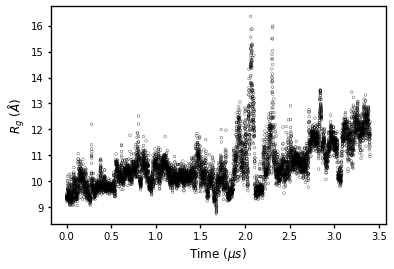

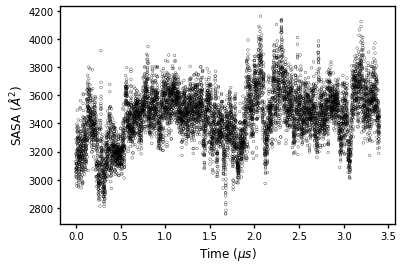

In [317]:
##### make Rgyr / SASA v time plots for explicit solvent sims
# 'step' has the proper value to match a frame! 
print(list(replica_c_data[0]), replica_c_data[0].shape)
print_values = True
save_cell = False
if explicit:
    init = replica_c_data[0]['step'].iloc[0]
    replica_c_data[0]['step'] = replica_c_data[0]['step']-init
    replica_c_data[0]['time'] = 0.000400*replica_c_data[0]['step'] ### puts the time in microseconds
    ### USE THIS TO MAP A TIME (us) TO THE FRAME NEEDED FOR PLOTTING
    if print_values:
        for e1,e2 in zip(replica_c_data[0]['step'],replica_c_data[0]['time']):
            print(e1+100,e2)
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax.scatter(replica_c_data[0]['time'], replica_c_data[0]['Rgyr'], c='', edgecolor='k', s=7, linewidth=0.3)
    ax.set_xlabel('Time ($\mu s$)', fontname='Dejavu Sans', fontsize=12)
    ax.set_ylabel('$R_g$ ($\AA$)', fontname='Dejavu Sans', fontsize=12)
    width=1.35
    ax.spines['left'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    ax.spines['top'].set_linewidth(width)
    ax.tick_params(width=width)
    if savef:
        plt.savefig('Rgyr_v_time_{}_{}-to-{}.svg'.format(save_name,start,stop), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax.scatter(replica_c_data[0]['time'], replica_c_data[0]['SASA'], c='', edgecolor='k', s=7, linewidth=0.3)
    ax.set_xlabel('Time ($\mu s$)', fontname='Dejavu Sans', fontsize=12)
    ax.set_ylabel('SASA ($\AA^2$)', fontname='Dejavu Sans', fontsize=12)
    width=1.35
    ax.spines['left'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    ax.spines['top'].set_linewidth(width)
    ax.tick_params(width=width)
    if save_cell:
        plt.savefig('SASA_v_time_{}_{}-to-{}.svg'.format(save_name,start,stop), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()


load /media/ee/EE_external/MD/struct81_noncov_EXPLICIT_SOLV/run/pdbs_centered/Frame_.pdb


bg_color white

hide everything
show cartoon
show sticks
set valence, 0
hide (hydro)
spectrum count, firebrick_gray50_marine, chain A
color density, name N*
color firebrick, name O*
color paleyellow, name S*
color cyan, name F*

---add the following in before spectrum for noncov CA above
select pfps, chain B
color wheat, pfp 

set ray_trace_mode, 1;   
set ray_trace_gain, 0.1;     
set ray_shadow_decay_factor, 0.1;   
set ray_shadow_decay_range, 2;    
set antialias, 2;    
set reflect,0.5;
set shininess, 100;
set specular, 1;
set direct,0;
set reflect,1.5;
set light_count,10;
set spec_count,1;
ray

png /home/ee/Documents/Evans_lab/projects/MP01_MD_papers/MD_paper/Figures/t36_f1000_test.png, dpi=300
delete Frame_


In [180]:
## write pymol script to load in desired cluster and example frames and align to center
write_cluster_examples = True
if write_cluster_examples:
    caps = True #CA_noncov = True, CA_cov = True, test32/37 = False
    pdb_path = '/media/ee/EE_external/MD/{}/pdbs/0/'.format(path.split('/')[-2])
    for i in center_size_df.index:
#         print(center_size_df.head)
        cent = X.loc[center_size_df.loc[i,'center_index']].values.reshape(1, -1)
        cent = list(pca.transform(cent)[0][:2])
        f_num = str(center_size_df.loc[i,'frame'])
        if combine_8_1s:
            caps = False
#             print( center_size_df.loc[i,'frame'],center_size_df.loc[i,'center_index'] )
            if center_size_df.loc[i,'frame'] != center_size_df.loc[i,'center_index']:
                pdb_path = '/media/ee/EE_external/MD/8_1_test37_REMD_2/pdbs/0/'
            else:
                pdb_path = '/media/ee/EE_external/MD/8_1_test32_REMD_1/pdbs/0/'
        f_name = '{}_distthresh_{}_center_{}_size_{}_PCA_{}_{}.py'.format(save_name,dist_thresh, 
                                                                          center_size_df.loc[i,'frame'],
                                                                          str(round(center_size_df.loc[i,'cluster_size']*100,3)).replace('.','_'),
                                                                          cent[0], cent[1])
        if caps:
            frame = 'Frame_' 
        else:
            frame = 'frame_'
        center = frame+f_num+'.pdb'
        with open(os.path.join(path,f_name), 'w') as f:
            f.write('from pymol import cmd \n')
            f.write('import sys \n')
            f.write('cmd.load("{}") \n'.format(os.path.join(pdb_path,center)))
            f.write('cmd.bg_color("white") \n')
            f.write('cmd.cartoon("automatic","frame_{}") \n'.format(f_num))
            f.write('cmd.show("sticks","frame_{}") \n'.format(f_num))
            f.write('cmd.remove("hydro") \n')
            f.write('cmd.spectrum("count", "firebrick_gray50_marine", "frame_{}") \n'.format(f_num))
            f.write('cmd.valence("1", "frame_{}") \n'.format(f_num))
            f.write('cmd.color("density", "name N*") \n')
            f.write('cmd.color("firebrick", "name O*") \n')
            f.write('cmd.color("paleyellow", "name S*") \n')
            for ele in center_size_df.loc[i,'example_frames']:
                pdb = frame+str(ele)+'.pdb'
                f.write('cmd.load("{}") \n'.format(os.path.join(pdb_path,pdb)))
                f.write('cmd.cartoon("automatic","{}") \n'.format(pdb[:-4]))
                f.write('cmd.spectrum("count", "firebrick_gray90_marine", "{}") \n'.format(pdb[:-4]))
                f.write('cmd.align("{} and resi {}-{}", "{}") \n'.format(frame+str(ele),start,stop,frame+f_num))

bg_color white

show cartoon
show sticks
set valence, 0
hide (hydro)
spectrum count, firebrick_gray50_marine, chain A
color density, name N*
color firebrick, name O*
color paleyellow, name S*

## once you find the view point you like in pymol run the following:
set ray_trace_mode, 1;   
set ray_trace_gain, 0.1;     
set ray_shadow_decay_factor, 0.1;   
set ray_shadow_decay_range, 2;    
set antialias, 2;    
set reflect,0.5;
set shininess, 100;
set specular, 1;
set direct,0;
set reflect,1.5;
set light_count,10;
set spec_count,1;
ray

### for the Gen4+CA:
select pfps, chain B;
hide sticks, pfps;
color wheat, pfps;
show surface, pfps;
set transparency, 0.3
## then
set ray_trace_mode, 1   
set ray_trace_gain, 0.1;     
set ray_shadow_decay_factor, 0.1;   
set ray_shadow_decay_range, 2;    
set antialias, 2;    
set reflect,0.5;
set shininess, 100;
set specular, 1;
set direct,0;
set reflect,1.5;
set light_count,10;
set spec_count,1;
ray



show cartoon, all
select cpf, resn CPF;
hide sticks, cpf;
show surface, cpf;
set transparency, 0.3
# then on cluster center turn on sticks (liq) and then color
set ray_trace_mode, 1   
set ray_trace_gain, 0.1;     
set ray_shadow_decay_factor, 0.1;   
set ray_shadow_decay_range, 2;    
set antialias, 2;    
set reflect,0.5;
set shininess, 100;
set specular, 1;
set direct,0;
set reflect,1.5;
set light_count,10;
set spec_count,1;
ray



<Figure size 180x180 with 0 Axes>

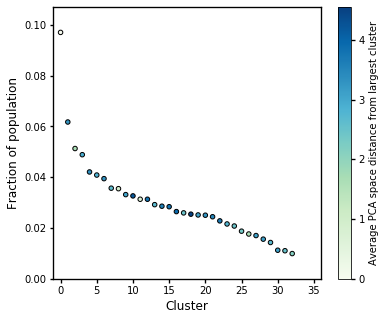

9867


In [182]:
    
full_plot = False
    
cluster_sizes = get_cluster_size(agg_clust)
if full_plot:
    p_size = 5
    s = 40
else:
    p_size = 2.5
    s = 20
cluster_sizes = [(kv[0],kv[1],c) for kv,c in zip(cluster_sizes.items(),c_list)]
sizes = sorted(cluster_sizes, key=lambda x:x[1],reverse=True)
fig = plt.figure(figsize=(p_size,p_size))
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax = plt.subplot()
x_dom = [i for i in range(len(sizes))]
y_dom = [v[1]/X.shape[0] for v in sizes]
sorted_c_list = [ele[2] for ele in sizes]
im = ax.scatter(x_dom, y_dom,  s=s, c=sorted_c_list, edgecolor='k', cmap=c_map)
cbar = plt.colorbar(im)
cbar.set_label('Average PCA space distance from largest cluster', fontsize=10)
## for full non log plot:
if full_plot:
    ax.set_xlim([-1,100])
## for just the first 50 clusters for better resolution
else:
    ax.set_xlim([-1,len(x_dom)+3])
ax.set_ylim([0,max(y_dom)+0.01])
ax.set_xlabel('Cluster', fontsize=12,fontname='Dejavu Sans')
ax.set_ylabel('Fraction of population', fontsize=12,fontname='Dejavu Sans')
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
cbar.ax.tick_params(width=width)
if savef:
    plt.savefig('cluster_sizes_{}_{}-to-{}_top40_{}.svg'.format(save_name,start,stop,sum([v[1] for v in sizes[:40]])), format='svg', dpi=1000, bbox_inches='tight')
plt.show()

print(sum([v[1] for v in sizes[:40]]))
# medoid_size = [(med,size) for med,size in zip(kmedoids.medoid_indices_, cluster_sizes.values())]
# sizes = sorted(medoid_size, key=lambda x:x[1],reverse=True)
# plt.scatter([i for i in range(len(sizes))], [ele[1] for ele in sizes], c='c', edgecolor='k', s=20)
# plt.show()

# Z = linkage(np.vstack(X_centers), 'average')
# plt.figure(figsize=(5,5))
# dendrogram(Z, p=8, truncate_mode='level', leaf_rotation=90) # 
# plt.show()

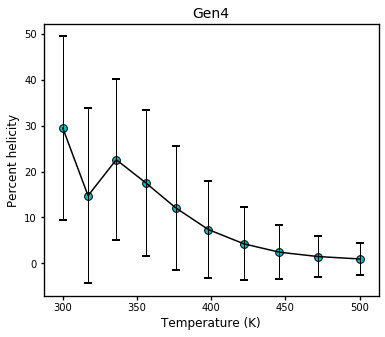

In [169]:
## calc % helicity v. temp for REMD
def get_percents(entry):
    entries = {}
    for l in entry:
        if l !=' ':
            if l not in entries:
                entries[l] = 1
            else:
                entries[l] += 1
    percents = {}
    for k,v in entries.items():
        percents[k] = round(float(v/29.0)*100,3)
    return percents

def get_avg_data(terms,data):
    to_avg = []
    for ss_info in data:
        ss_sum = 0
        for l in terms:
            if l in ss_info:
                ss_sum+=ss_info[l]
            else:
                pass
        to_avg.append(ss_sum)
    to_avg = np.asarray(to_avg)
    return to_avg.mean(), to_avg.std()

helicity = []
helicity_std = []
temps = [300,317,336,356,376,398,422,446,472,500]
for rep,temp in zip(SS,temps):
    ss_data = SS[rep].apply(get_percents)
    heli_mean, heli_std  = get_avg_data(['H', 'G', 'I'], ss_data)
    helicity.append(heli_mean)
    helicity_std.append(heli_std)

fig,ax = plt.subplots(1,1,figsize=(6,5))   
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Percent helicity', fontsize=12)
plt.title('Gen4', fontsize=14)
plt.errorbar(temps,helicity, yerr=helicity_std, elinewidth=1, ecolor='k', capsize=4, capthick=2, c='k')
plt.scatter(temps,helicity, c='c', edgecolor='k', s=60)
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
plt.savefig('{}_helicity_v_temp.svg'.format(save_name), format='svg', dpi=1000, bbox_inches='tight')
plt.show()

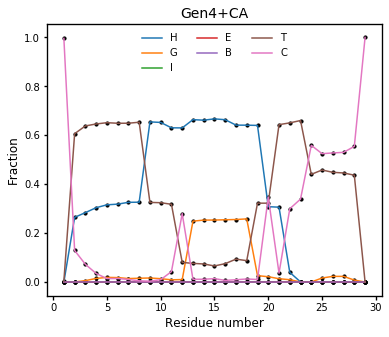

In [183]:
## graph of the SS ensembles for the different residues for each labeling state
# SS[0].loc[750].split()

def get_ss_chars(entry):
    return entry.split()

def get_ss_profiles(data_mat):
    '''
    H - Alpha helix
    G - 3-10 helix
    I - PI-helix
    E - Extended conformation
    B or b - Isolated bridge
    T - Turn
    C - Coil (none of the above)
    '''
    structure_type = {}
    for struct in ['H', 'G', 'I', 'E', 'B', 'T', 'C']:
        data_cpy = data_mat.copy()
        data_cpy[data_cpy==struct] = 1
        data_cpy[data_cpy!='1'] = 0
        data_cpy = data_cpy.astype(int)
        struct_mean = data_cpy.mean(axis=0)
        struct_std = data_cpy.std(axis=0)
        structure_type[struct] = [struct_mean, struct_std]
    return structure_type
        
ss_0_split = SS[0].apply(get_ss_chars)
ss_0_matrix = np.vstack(ss_0_split.values)
ss_profile = get_ss_profiles(ss_0_matrix)

# fig, ax = plt.subplots(1,1, figsize=(8,5))
x = [i for i in range(1,30)]
fig,ax = plt.subplots(1,1,figsize=(6,5))  
for ss in ss_profile:
    ax.scatter(x,ss_profile[ss][0], s=10, c='k')
    ax.errorbar(x,ss_profile[ss][0], label=ss) #, yerr=ss_profile[ss][1])
plt.legend(frameon=False, ncol=3)
plt.xlabel('Residue number', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.title('Gen4+CA', fontsize=14)
width=1.35
ax.spines['left'].set_linewidth(width)
ax.spines['bottom'].set_linewidth(width)
ax.spines['right'].set_linewidth(width)
ax.spines['top'].set_linewidth(width)
ax.tick_params(width=width)
plt.savefig('{}_SS.svg'.format(save_name), format='svg', dpi=1000, bbox_inches='tight')
plt.show()